In [1]:
from qampy import signals, impairments, equalisation, phaserec, helpers
from qampy.theory import ber_vs_es_over_n0_qam as ber_theory
from qampy.helpers import normalise_and_center as normcenter
from qampy.core.filter import rrcos_pulseshaping as lowpassFilter
import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from scipy.stats import kde
import seaborn as sns
import pandas as pd

output_notebook()

Loading BokehJS ...

In [31]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [16,8]
plt.rcParams['lines.linewidth'] = 2

In [3]:
def plot_constellation(E):
    
    npol = E.shape;
    fig = figure(title="QAM snal constellation", output_backend="webgl")
    
    if npol[0] == 2:        
        fig.scatter(E[0].real, E[0].imag, color='red', alpha=0.3, legend_label="X")
        fig.scatter(E[1].real, E[1].imag, color='blue', alpha=0.3, legend_label="Y")        
    elif npol[0] == 1:       
        fig.scatter(E[0].real, E[0].imag, color='red', alpha=0.3, legend_label="X")        
 
        
    fig.xaxis[0].axis_label = "In-Phase"
    fig.yaxis[0].axis_label = "Quadrature"
    show(fig)
    
def plot_constellation_fancy(E):
    npol = E.shape;
        
    nbins=100
    if npol[0] == 2: 
        for indPlot in range(0,2):
            x = E[indPlot].real
            y = E[indPlot].imag
            
            k = kde.gaussian_kde([x,y])
            xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
            # Make the plot
            plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
            plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Blues')
            plt.show()
    elif npol[0] == 1:
        x = E[0].real
        y = E[0].imag

        k = kde.gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
        # Make the plot
        plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
        plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Blues')
        plt.show()

In [127]:
# Geração do sinal QAM

M   = 64        # ordem da modulação
Fb  = 40e9      # taxa de símbolos
SpS = 4         # amostras por símbolo
Fs  = SpS*Fb    # taxa de amostragem
SNR = 40        # relação sinal ruído (dB)
rolloff = 0.01  # Rolloff do filtro formatador de pulso

# Gera sequência de símbolos QAM e a filtra com um filtro formatador de pulso rrc (root-raised cosine)
s = signals.ResampledQAM(M, 2**16, fb=Fb, fs=Fs, nmodes=2, resamplekwargs={"beta":rolloff, "renormalise":True}) 

# Adiciona ruído gaussiano
s = impairments.simulate_transmission(s, snr=SNR)

# Detecção do sinal com filtro casado + downsampling e normalização do sinal para energia média 1 
# (para visualização da constelação)

symb = normcenter(s.resample(fnew=Fb, beta = rolloff))

# Plota constelação
#plot_constellation(symb)
#plot_constellation_fancy(symb)

# Caclula parâmetros de desempenho
SNR_est = 10*np.log10(symb.est_snr())
GMI_est = symb.cal_gmi()

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
print("Parâmetros de desempenho:\n")
print("SNR estimada da constelação: ", np.array2string(SNR_est), " dB")
print("GMI estimada da constelação: ", np.array2string(GMI_est[0][0]), np.array2string(GMI_est[0][1]), " bits/symb")
print("BER: ", symb.cal_ber())
print("BER (teórica): ", np.array2string(ber_theory(helpers.dB2lin(SNR),M)))

Parâmetros de desempenho:

SNR estimada da constelação:  [39.870940 39.934312]  dB
GMI estimada da constelação:  5.986253 -inf  bits/symb
BER:  [0.000003 0.000003]
BER (teórica):  0.000000


(array([0.000000, 0.000000, 0.000000, ..., 0.000000, 0.000000, 0.000000]),
 array([-80000000000.000000, -79999389648.437500, -79998779296.875000, ...,
        79998168945.312500, 79998779296.875000, 79999389648.437500]),
 <matplotlib.lines.Line2D at 0x29e9209fe48>)

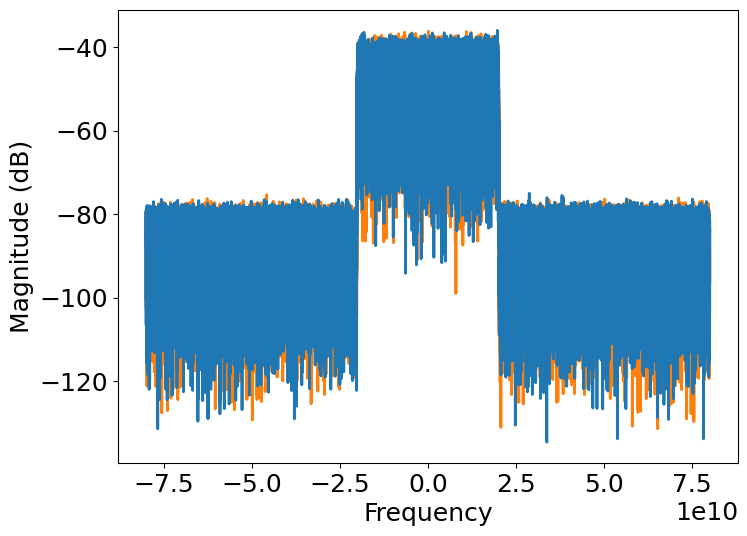

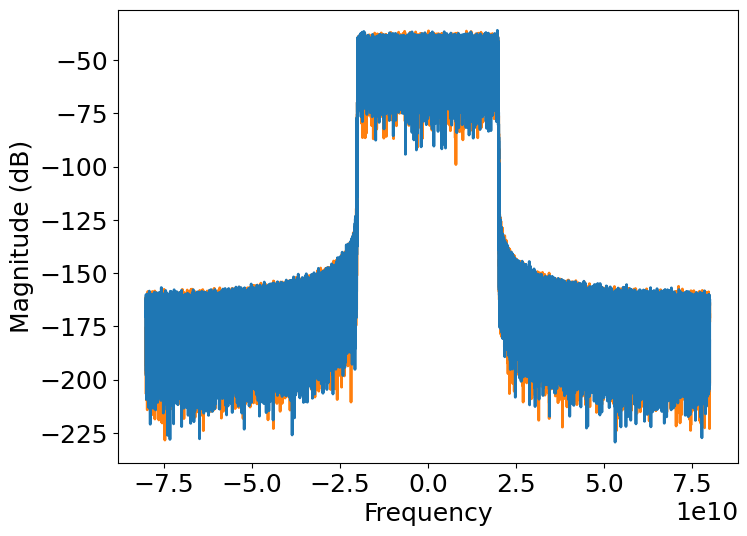

In [128]:
# Plota espectro do sinal QAM em banda base
fig = plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(s[0],Fs=s.fs,scale='dB',color='C1')
plt.magnitude_spectrum(s[1],Fs=s.fs,scale='dB',color='C0')

# Filtra ruído fora da banda do sinal (out-of-band noise)
sfilt = normcenter(lowpassFilter(s, Fs, 1/Fb, 0.001, taps=4001))
fig = plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(sfilt[0],Fs=s.fs,scale='dB',color='C1')
plt.magnitude_spectrum(sfilt[1],Fs=s.fs,scale='dB',color='C0')

(array([0.000000, 0.000000, 0.000000, ..., 0.000000, 0.000000, 0.000000]),
 array([-80000000000.000000, -79999389648.437500, -79998779296.875000, ...,
        79998168945.312500, 79998779296.875000, 79999389648.437500]),
 <matplotlib.lines.Line2D at 0x29e93b711c8>)

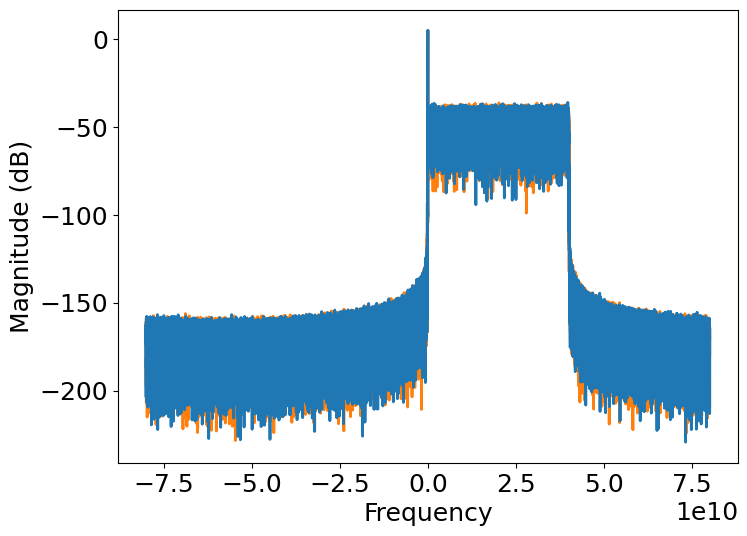

In [129]:
# Gera sinal de fase mínima (sfm(t) = A + s(t)*exp(j*2π*Δf*t))

sfm = sfilt.copy()

t = np.arange(0,s[0].size)*1/s.fs

A  = 1.8
Δf = 2*np.pi*(sfilt.fb/2)*t
sfm = A + sfilt*np.exp(1j*Δf)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(sfm[0],Fs=s.fs,scale='dB',color='C1')
plt.magnitude_spectrum(sfm[1],Fs=s.fs,scale='dB',color='C0')

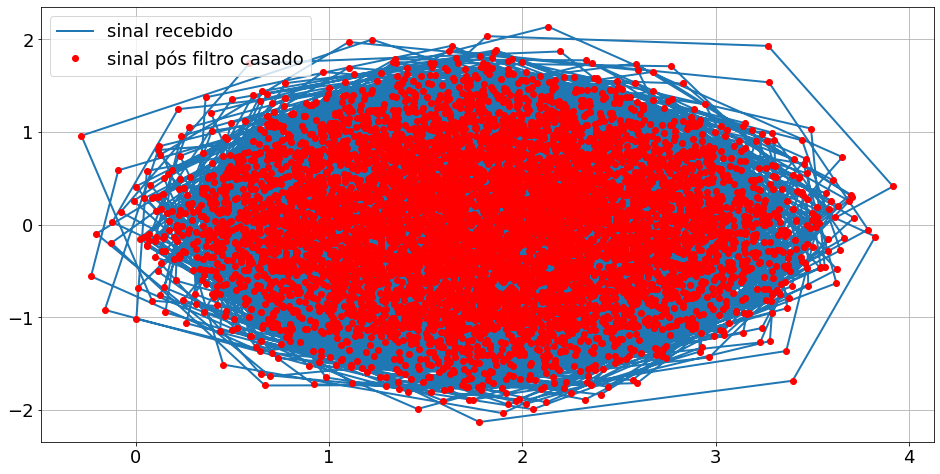

In [130]:
plt.figure(figsize=(16,8))
plt.plot(sfm[0,:10000].real,sfm[0,:10000].imag)
plt.plot(sfm[0,:10000].real,sfm[0,:10000].imag,'ro')
plt.legend(['sinal recebido','sinal pós filtro casado'])
plt.grid(True)

Text(0, 0.5, 'Phase (rad)')

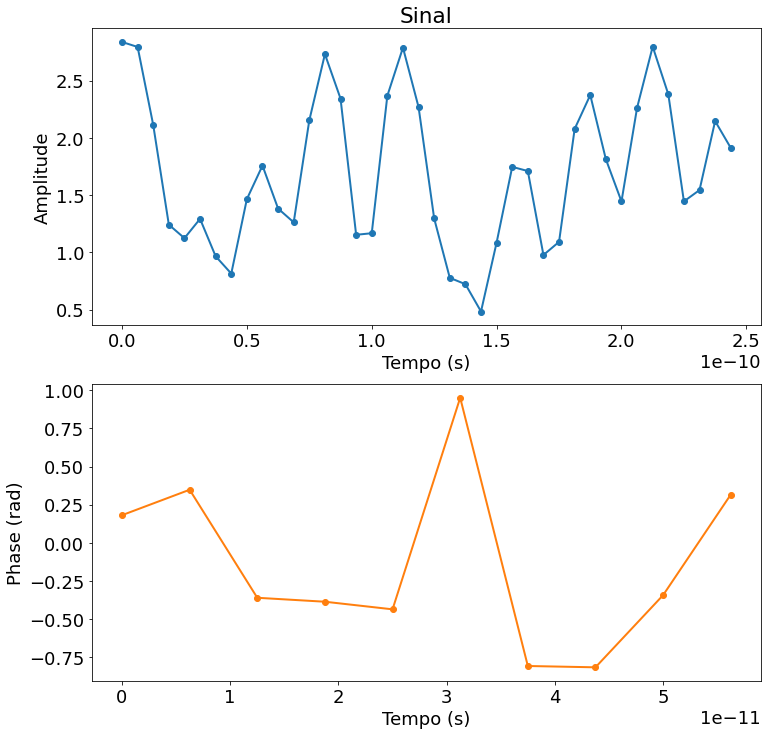

In [131]:
amplitudes_train = np.abs(sfm[0])   # valor absoluto do sinal -> entrada da rede
phases_train     = np.angle(sfm[0,::SpS]) # fase do sinal           -> saída desejada 

amplitudes_test = np.abs(sfm[1])   # valor absoluto do sinal -> entrada da rede
phases_test     = np.angle(sfm[1,::SpS]) # fase do sinal           -> saída desejada 

L = 10
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

axes[0].set_title("Sinal")
axes[0].plot(t[0:int(4*L)], amplitudes_train[0:int(4*L)],'-o', color='C0')
axes[0].set_xlabel("Tempo (s)")
axes[0].set_ylabel("Amplitude")

axes[1].plot(t[0:L], phases_train[0:L],'-o', color='C1')
axes[1].set_xlabel("Tempo (s)")
axes[1].set_ylabel("Phase (rad)")

In [226]:
X_train = amplitudes_train.reshape(-1,SpS)[:5000]
X_test = amplitudes_test.reshape(-1,SpS)[:5000]

In [227]:
y_train = phases_train.reshape(-1,1)[:5000]

y_test = phases_test.reshape(-1,1)[:5000]

In [228]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [229]:
scaler = MinMaxScaler()
#scaler = StandardScaler()

In [230]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [231]:
import tensorflow as tf

In [232]:
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error,r2_score

In [233]:
gerador = TimeseriesGenerator(X_train,y_train,length=1,batch_size=1)

valid = TimeseriesGenerator(X_test,y_test,length=1,batch_size=1)

In [234]:
stop = EarlyStopping(monitor='val_loss',patience=10)

In [272]:
# define model
model = Sequential()
model.add(Dense(100,activation='relu',input_shape=(SpS,)))
model.add(Dense(200,activation='relu'))
Dropout(0.2)
model.add(Dense(200,activation='relu'))
Dropout(0.2)
model.add(Dense(200,activation='relu'))
Dropout(0.2)
model.add(Dense(100,activation='relu'))
Dropout(0.2)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [273]:
#model.summary()

In [274]:
#model.fit_generator(gerador,epochs=20,validation_data=valid, callbacks=[stop])
model.fit(X_train,y_train,epochs=300,callbacks=[stop],
validation_data=(X_test,y_test))

Epoch 1/300
157/157 [==============================] - 1s 5ms/step - loss: 0.0895 - val_loss: 0.0449
Epoch 2/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0422 - val_loss: 0.0378
Epoch 3/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0382 - val_loss: 0.0386
Epoch 4/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0349 - val_loss: 0.0371
Epoch 5/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0372 - val_loss: 0.0362
Epoch 6/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0371 - val_loss: 0.0422
Epoch 7/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0350 - val_loss: 0.0354
Epoch 8/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0328 - val_loss: 0.0333
Epoch 9/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0349 - val_loss: 0.0357
Epoch 10/300
157/157 [==============================] - 1s 4ms/step - loss: 0.0330 - val_lo

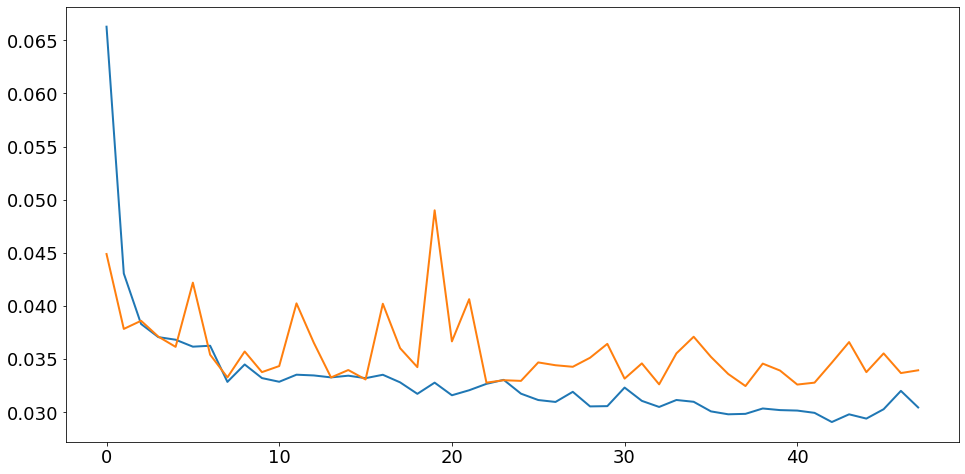

In [275]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [276]:
#preds = []
#for n in range(len(X_train)):
#    pred = model.predict(X_test[n].reshape(1,1,4))[0][0]
#    preds.append(pred)
#preds = np.array(preds).reshape(-1,1)

preds = model.predict(X_test)

In [277]:
test = np.concatenate((preds,y_test),axis=1)
print(test[:5])

[[-0.243579 -0.145749]
 [-0.249081 -0.052073]
 [-0.084229 0.350426]
 [-0.150027 0.086277]
 [0.110367 0.342508]]


In [278]:
print('mse = ', mean_squared_error(y_test,preds))
print('r2 = ' , r2_score(y_test,preds))

mse =  0.03395315628208975
r2 =  0.8188938016230732


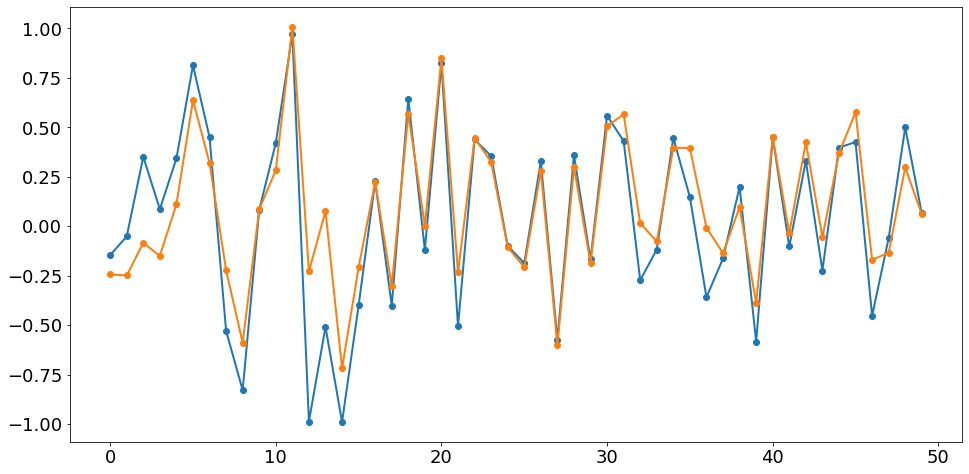

In [279]:
plt.plot(y_test[:50],'-o')
plt.plot(preds[:50],'-o')

In [244]:
pd.DataFrame(y_test).describe()

,0
count,5000.000000
mean,-0.007433
std,0.433029
min,-1.002407
25%,-0.332962
50%,-0.053028
75%,0.328539
max,0.998244


<AxesSubplot:ylabel='Count'>

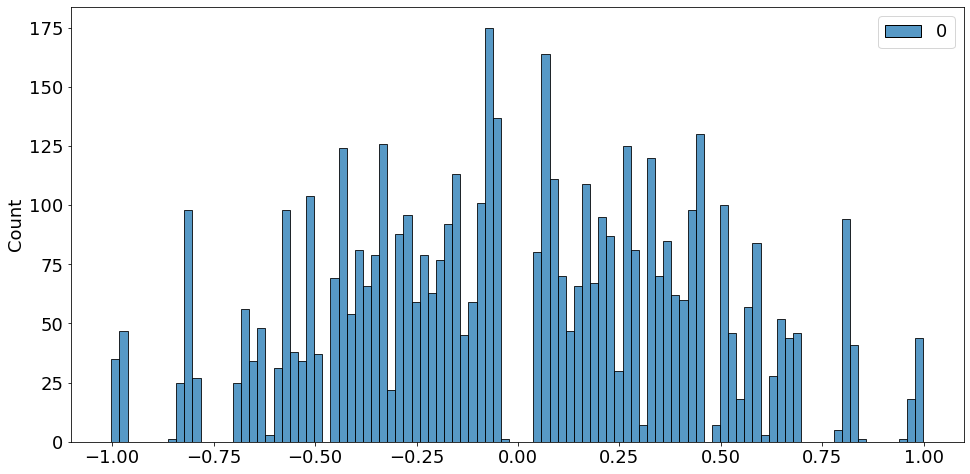

In [256]:
sns.histplot(pd.DataFrame(y_test),bins=100)

In [266]:
dataset_train = np.concatenate((X_train,y_train),axis=1)
dataset_test = np.concatenate((X_test,y_test),axis=1)

In [263]:
np.corrcoef(dataset.T).shape

(5, 5)

<AxesSubplot:>

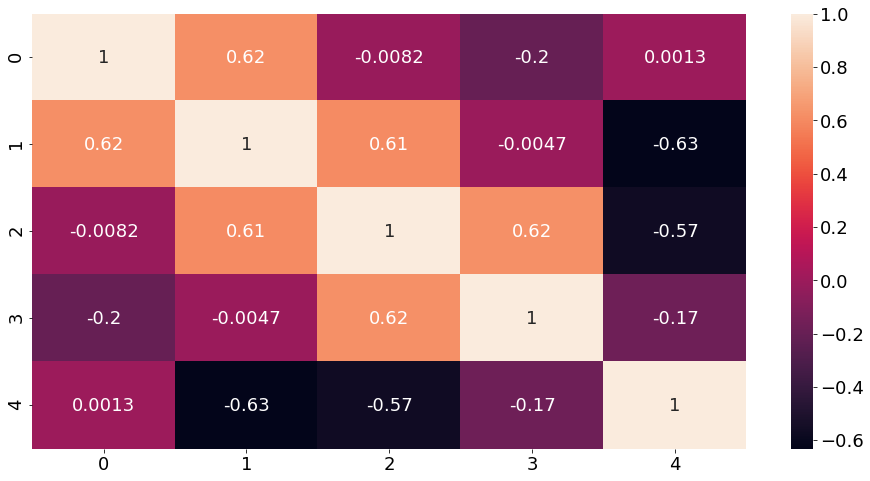

In [267]:
sns.heatmap(np.corrcoef(dataset_train.T),annot=True)

<AxesSubplot:>

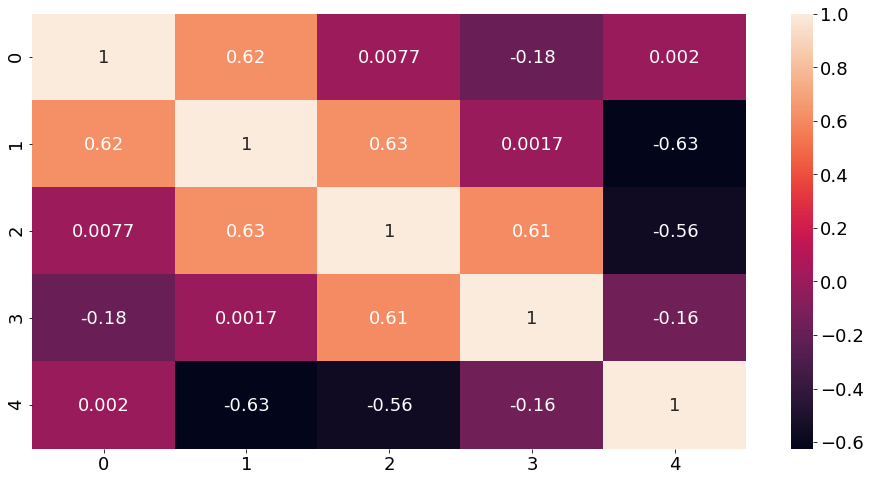

In [268]:
sns.heatmap(np.corrcoef(dataset_test.T),annot=True)